# Mustererkennung/Machine Learning WiSe 18/19
# Assignment 3
## Adrian Gruszczynski Yann Salimi

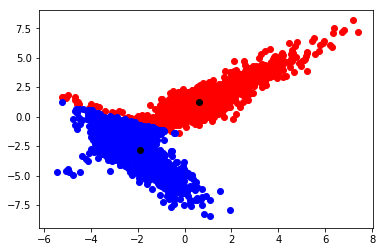

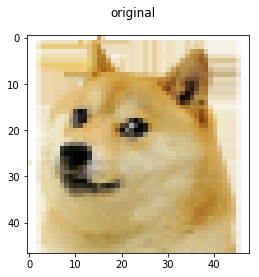

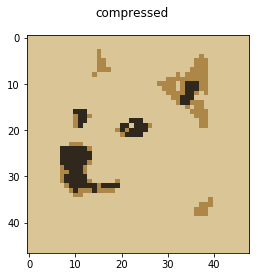

In [8]:
import numpy as np
import pandas as pd
import scipy.stats as scp
import matplotlib.pyplot as plt
import cv2 as cv


class Cluster:
    def __init__(self, mu, cov_m, mix):
        self.mu = mu
        self.cov_m = cov_m
        self.mix = mix
        self.points = np.array([])

    def update(self, mu, cov_m, mix):
        self.mu = mu
        self.cov_m = cov_m
        self.mix = mix


class GMM:
    def __init__(self, data, n_clusters):
        self.data = data
        self.n_clusters = n_clusters
        self.n_samples, self.n_features = self.data.shape
        self.cov_m = np.cov(data, rowvar=False)
        self.mix = 0.5
        self.mu = np.random.uniform(np.min(self.data), np.max(self.data), size=(self.n_clusters, self.n_features))
        self.clusters = [Cluster(self.mu[i], self.cov_m, self.mix) for i in range(self.n_clusters)]
        self.logLH = 0
        self.resp = []

    def e_step(self):
        nom = [
            self.clusters[i].mix * scp.multivariate_normal.pdf(self.data, self.clusters[i].mu, self.clusters[i].cov_m)
            for i in range(self.n_clusters)]
        den = np.sum(nom, axis=0)
        self.resp = np.array([nom[i] / den for i in range(self.n_clusters)])

    def m_step(self):
        m_c = [np.sum(self.resp[i]) for i in range(self.n_clusters)]
        self.mix = np.divide(m_c, self.n_samples)
        self.mu = [np.sum(self.resp[i, :].reshape(self.n_samples, 1) * self.data, axis=0) / m_c[i] for i in
                   range(self.n_clusters)]
        self.cov_m = np.cov(self.data, aweights=np.tile(abs(np.mean(self.mu)), self.n_samples), rowvar=False)[0]
        self.logLH = np.log(np.sum(m_c))

    def update_clusters(self):
        for i in range(self.n_clusters):
            self.clusters[i].update(self.mu[i], self.cov_m, self.mix[i])

    def plot(self):
        blue = []
        red = []
        for index, point in enumerate(self.data):
            if self.resp[0][index] > self.resp[1][index]:
                blue.append(point)
            else:
                red.append(point)
        if len(red) > 0:
            plt.scatter(np.array(red)[:, 0], np.array(red)[:, 1], c='r')
        if len(blue) > 0:
            plt.scatter(np.array(blue)[:, 0], np.array(blue)[:, 1], c='b')

        centers = [self.clusters[i].mu for i in range(n_clusters)]
        plt.scatter(centers[0][0], centers[0][1], c='k')
        plt.scatter(centers[1][0], centers[1][1], c='k')

        plt.show()

    def compress(self):
        for i in range(self.n_samples):
            cluster = np.argmax(self.resp[:, i])
            self.data[i] = self.clusters[cluster].mu
        self.data = self.data.reshape(47, 48, 3)


if __name__ == '__main__':
    df = pd.read_csv('2d-em.csv', header=None)
    data = np.array(df)

    n_clusters = 2
    _GMM = GMM(data, n_clusters)
    _best_logLH = float('-inf')
    _best_GMM = None

    for i in range(1, 10):
        _GMM.e_step()
        _GMM.m_step()
        _GMM.update_clusters()
        if _GMM.logLH > _best_logLH:
            best_logLH = _GMM.logLH
            _best_GMM = _GMM

    _best_GMM.plot()

    ## Exercise 2

    rgb = cv.imread('doge.png')
    plt.imshow(cv.cvtColor(rgb, cv.COLOR_BGR2RGB))
    plt.suptitle('original')
    plt.show()

    data = rgb.reshape(2256, 3)
    n_clusters = 20
    n_samples, n_features = data.shape
    _GMM = GMM(data, n_clusters)
    _best_logLH = float('-inf')
    _best_GMM = None

    for i in range(1, 20):
        _GMM.e_step()
        _GMM.m_step()
        _GMM.update_clusters()
        if _GMM.logLH > _best_logLH:
            best_logLH = _GMM.logLH
            _best_GMM = _GMM

    _best_GMM.compress()
    plt.imshow(cv.cvtColor(_best_GMM.data, cv.COLOR_BGR2RGB))
    plt.suptitle('compressed')
    plt.show()


# Appendix to Exercise2
### Choosing the right mu's

One possible solution one could think of would be to run k means algorith on the given data to get the 'hard' clusters in order to find the initial mu's that we could later use to initialize our GMM.

An other solution could be choosing the initial centers in such way, that the distances between each center are not too small.